In [2]:
 #install some libraries 
!pip install numpy
!pip install qutip


[notice] A new release of pip available: 23.1.1 -> 23.2
[notice] To update, run: pip install --upgrade pip
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.2/16.2 MB 11.9 MB/s eta 0:00:0000:0100:01

[notice] A new release of pip available: 23.1.1 -> 23.2
[notice] To update, run: pip install --upgrade pip


In [3]:
# We will need some functionality 
from typing import List 

# and from math related libraries
import numpy as np
import qutip as qt

# and from qiskit
from qiskit.extensions import HamiltonianGate
from qiskit import QuantumCircuit, QuantumRegister, Aer, execute
from qiskit.providers.aer import QasmSimulator
from qiskit.quantum_info import Operator

In [4]:
from numbers import Number
import numpy

from qiskit.circuit import Gate, QuantumCircuit, QuantumRegister, ParameterExpression
from qiskit.quantum_info.operators.predicates import matrix_equal
from qiskit.quantum_info.operators.predicates import is_hermitian_matrix
from qiskit.extensions.exceptions import ExtensionError
from qiskit.circuit.exceptions import CircuitError

from qiskit.circuit import Parameter, QuantumCircuit, QuantumRegister 


from qiskit.extensions.unitary import UnitaryGate

# The code in this cell is based on https://github.com/Qiskit/qiskit-terra/blob/main/qiskit/extensions/hamiltonian_gate.py licenced under Apache licence.
class CustomHamiltonianGate(Gate):
    def __init__(self, time, num_qubits, connectivity, h_coeff0,h_coeff1,h_coeff2,h_coeff3, label=None):
        if isinstance(time, Number) and time != numpy.real(time):
            raise ExtensionError("Evolution time is not real.")
       
        self.num_qubits = num_qubits
        self.connectivity = connectivity
        # Store instruction params
        super().__init__("custom_hamiltonian", num_qubits, [time, num_qubits, connectivity, h_coeff0,h_coeff1,h_coeff2,h_coeff3], label=label)

    def __array__(self, dtype=None):
        """Return matrix for the unitary."""
        # pylint: disable=unused-argument
        import scipy.linalg

        try:
            return scipy.linalg.expm(-1j * self.get_ham() * float(self.params[0]))
        except TypeError as ex:
            raise TypeError(
                "Unable to generate Unitary matrix for "
                "unbound t parameter {}".format(self.params[1])
            ) from ex

    def _define(self):
        """Calculate a subcircuit that implements this unitary."""
        q = QuantumRegister(self.num_qubits, "q")
        qc = QuantumCircuit(q, name=self.name)
        qc._append(UnitaryGate(self.to_matrix()), q[:], [])
        self.definition = qc

    def validate_parameter(self, parameter):
        return parameter

    def get_ham(self):
        dim = 2 ** self.num_qubits
        num_connections = len(self.connectivity)
        zz_hamiltonian = np.zeros([dim, dim], dtype=np.complex128)

        for c in range(num_connections):
            ops_to_tensor = [qt.identity(2)] * num_qubits
            ops_to_tensor[self.connectivity[c][0]] = qt.sigmaz()
            ops_to_tensor[self.connectivity[c][1]] = qt.sigmaz()
            zz_hamiltonian += float(self.params[3+c]) * np.array(qt.tensor(ops_to_tensor)) #+= 

        return zz_hamiltonian

def custom_hamiltonian(self, time, connectivity, h_coeff0,h_coeff1,h_coeff2,h_coeff3, qubits, label=None):
    """Apply hamiltonian evolution to qubits."""
    if not isinstance(qubits, list):
        qubits = [qubits]

    return self.append(CustomHamiltonianGate(time=time, num_qubits =len(qubits), connectivity=connectivity, h_coeff0=h_coeff0,h_coeff1=h_coeff1,h_coeff2 = h_coeff2,h_coeff3 = h_coeff3, label=label), qubits, [])


QuantumCircuit.custom_hamiltonian = custom_hamiltonian


In [5]:
print(custom_hamiltonian)

<function custom_hamiltonian at 0x7fdb84dab7f0>


# Create a parametrized circuit based on a digital-analog approach which combines digital single-qubit operations with analog Multiqubit entangling blocks.


In [6]:
# we use the given code above to create  a Ising Hamiltonian circuit and implimented with parametrized based single qubits
# The main reson is to reduce the errors coused by the increse of the depth of circuit as the two qubits gates is used, instead we replace it with entagled Hamiltonian block.

from qiskit.circuit import  ParameterVector
psi0 = ParameterVector('psi0', 4) # As we have 4 Qubits, so We have 4 Psi in the single analog block 
psi1 = ParameterVector('psi1', 4) # As we have 4 Qubits, so We have 4 Psi in the single analog block 
psi2 = ParameterVector('psi2', 4) # As we have 4 Qubits, so We have 4 Psi in the single analog block 

num_qubits = 4
qr = QuantumRegister(num_qubits)
circ3 = QuantumCircuit(qr)
# Building the Circuit 

#single gate operation
circ3.rx(np.pi/2,qr[0])
circ3.rx(np.pi/2,qr[1])
#entagled hamiltonian block
circ3.custom_hamiltonian(connectivity=[[0, 1],[0,2],[0,3]], h_coeff0=psi0[0], h_coeff1=psi0[1], h_coeff2=psi0[2] ,h_coeff3=psi0[3], time=1, qubits=[qr[0], qr[1], qr[2], qr[3]], label='analog block_1')
#single gate operation
circ3.rx(np.pi/2,qr[0])
circ3.rx(np.pi/2,qr[1])
circ3.barrier()

circ3.rx(np.pi/2,qr[0])
circ3.rx(np.pi/2,qr[2])
circ3.custom_hamiltonian(connectivity=[[0, 1],[0,2],[0,3]], h_coeff0=psi1[0], h_coeff1=psi1[1], h_coeff2=psi1[2] ,h_coeff3=psi1[3], time=1, qubits=[qr[0], qr[1], qr[2], qr[3]], label='analog block_2')
circ3.rx(np.pi/2,qr[0])
circ3.rx(np.pi/2,qr[2])
circ3.barrier()

circ3.rz(np.pi/2,qr[0])
circ3.rz(np.pi/2,qr[3])
circ3.custom_hamiltonian(connectivity=[[0, 1],[0,2],[0,3]], h_coeff0=psi2[0], h_coeff1=psi2[1], h_coeff2=psi2[2] ,h_coeff3=psi2[3], time=1, qubits=[qr[0], qr[1], qr[2], qr[3]], label='analog block_3')
circ3.rz(np.pi/2,qr[0])
circ3.rz(np.pi/2,qr[3])


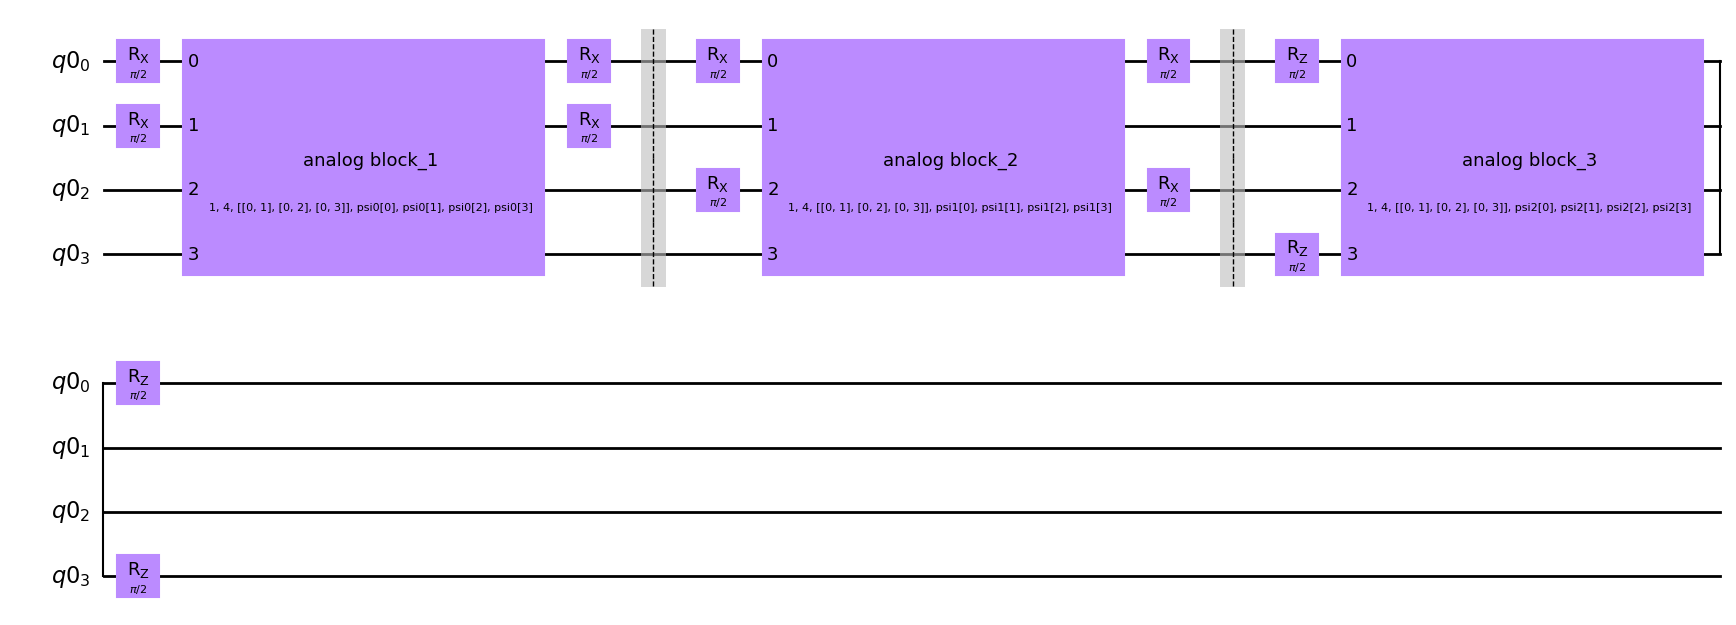

In [7]:
circ3.draw()

In [8]:
#Transpile the circuit
from qiskit.providers.aer import AerSimulator
from qiskit.compiler import transpile


bcirc3 = circ3.bind_parameters({psi0: [0, 0, 1, 1], psi1: [0, 0, 1, 1], psi2: [0, 0, 1, 1]} )

bcirc3.measure_all()

simulator = Aer.get_backend('aer_simulator') 
#bc3 = transpile(bc3, simulator) # added transpile step
job = execute(bcirc3, simulator, shots=1024, optimization_level=0)#, basis_gates=['ccx', 'cp', 'cswap', 'csx', 'cu', 'cu1', 'cu2', 'cu3', 'cx', 'cy', 'cz', 'delay', 'diagonal', 'h', 'id', 'initialize', 'mcp', 'mcphase', 'mcr', 'mcrx', 'mcry', 'mcrz', 'mcswap', 'mcsx', 'mcu', 'mcu1', 'mcu2', 'mcu3', 'mcx', 'mcx_gray', 'mcy', 'mcz', 'multiplexer', 'p', 'pauli', 'r', 'roerror', 'rx', 'rxx', 'ry', 'ryy', 'rz', 'rzx', 'rzz', 's', 'sdg', 'swap', 'sx', 'sxdg', 't', 'tdg', 'u', 'u1', 'u2', 'u3', 'unitary', 'x', 'y', 'z', 'kraus', 'qerror_loc', 'quantum_channel', 'roerror', 'save_amplitudes', 'save_amplitudes_sq', 'save_clifford', 'save_density_matrix', 'save_expval', 'save_expval_var', 'save_matrix_product_state', 'save_probabilities', 'save_probabilities_dict', 'save_stabilizer', 'save_state', 'save_statevector', 'save_statevector_dict', 'save_superop', 'save_unitary', 'set_density_matrix', 'set_matrix_product_state', 'set_stabilizer', 'set_statevector', 'set_superop', 'set_unitary', 'snapshot', 'superop', "custom_hamiltonian"])
        

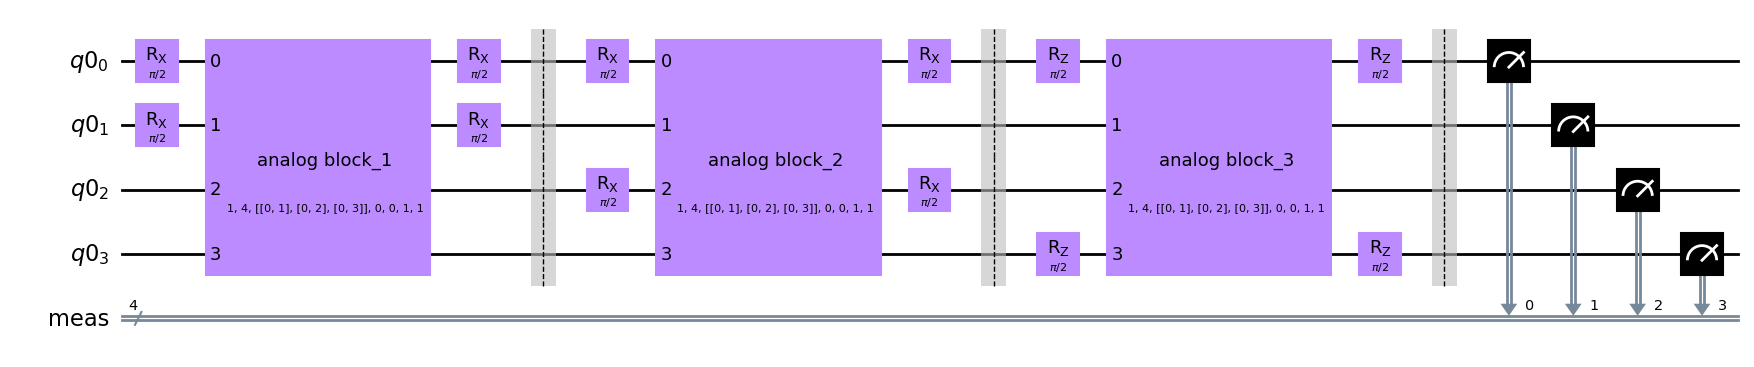

In [9]:
bcirc3.draw()

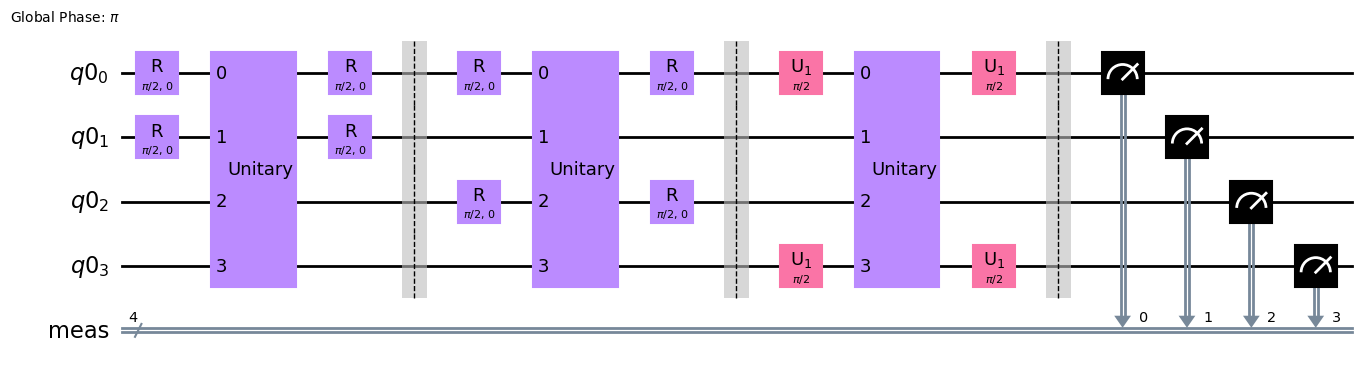

In [15]:
bcirc3.decompose().draw()

In [ ]:
result = job.result()
counts = result.get_counts(bcirc3)
print(counts)

{'0110': 1024}


 # We Apply the DAQC based circuit on Hydrogen molecule to test it.

In [21]:
import numpy as np
import pylab

from qiskit import Aer
from qiskit.utils import QuantumInstance, algorithm_globals
from qiskit.algorithms import VQE, NumPyMinimumEigensolver, NumPyEigensolver
from qiskit.algorithms.optimizers import SPSA, ADAM
from qiskit.opflow import I, X, Z
import numpy as np
import pylab

from qiskit import Aer
from qiskit.utils import QuantumInstance, algorithm_globals
from qiskit.algorithms import VQE, NumPyMinimumEigensolver
from qiskit.algorithms.optimizers import SPSA
from qiskit.circuit.library import TwoLocal
from qiskit.opflow import I, X, Z

# Aply the DAQC based circuit on Hydrogen molecule to test it

H2_op = (-1.052373245772859 * I ^ I ^ I ^I ) + \
        (0.39793742484318045 * I ^ Z ^ I ^I ) + \
        (-0.39793742484318045 * Z ^ I ^ I ^I ) + \
        (-0.01128010425623538 * Z ^ Z ^ I ^I ) + \
        (0.18093119978423156 * X ^ X ^ I ^I )
npme = NumPyMinimumEigensolver()
result = npme.compute_minimum_eigenvalue(operator=H2_op)
ref_value = result.eigenvalue.real
print(f'Reference value: {ref_value:.5f}')
seed = 500
iterations =125
algorithm_globals.random_seed = seed
backend = Aer.get_backend('aer_simulator')
qi = QuantumInstance(backend=backend, seed_simulator=seed, seed_transpiler=seed) 

counts = []
values = []
def store_intermediate_result(eval_count, parameters, mean, std):
    counts.append(eval_count)
    values.append(mean)

#ansatz = TwoLocal(rotation_blocks='ry', entanglement_blocks='cz')
#The prametrized circuit
ansatz = circ3


spsa = SPSA(maxiter=iterations)
vqe = VQE(ansatz, optimizer=spsa, callback=store_intermediate_result, quantum_instance=qi)
result = vqe.compute_minimum_eigenvalue(operator=H2_op)
print(f'VQE on Aer qasm simulator (no noise): {result.eigenvalue.real:.5f}')
print(f'Delta from reference energy value is {(result.eigenvalue.real - ref_value):.5f}')

Reference value: -1.85728
VQE on Aer qasm simulator (no noise): -1.84651
Delta from reference energy value is 0.01077


Text(0.5, 1.0, 'Convergence with no noise')

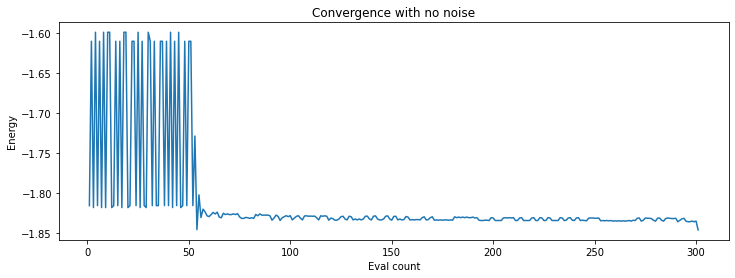

In [22]:
pylab.rcParams['figure.figsize'] = (12, 4)
pylab.plot(counts, values)
pylab.xlabel('Eval count')
pylab.ylabel('Energy')
pylab.title('Convergence with no noise')

# Run in the noisy backend

In [ ]:
import os
from qiskit.providers.aer import QasmSimulator
from qiskit.providers.aer.noise import NoiseModel
from qiskit.test.mock import FakeVigo
device_backend = FakeVigo()

backend = Aer.get_backend('aer_simulator')
counts1 = []
values1 = []
noise_model = None
device = QasmSimulator.from_backend(device_backend)
coupling_map = device.configuration().coupling_map
noise_model = NoiseModel.from_backend(device)
basis_gates = noise_model.basis_gates

print(noise_model)
print()

algorithm_globals.random_seed = seed
qi = QuantumInstance(backend=backend, seed_simulator=seed, seed_transpiler=seed,
                     coupling_map=coupling_map, noise_model=noise_model,)

def store_intermediate_result1(eval_count, parameters, mean, std):
    counts1.append(eval_count)
    values1.append(mean)

#ansatz = TwoLocal(rotation_blocks='ry', entanglement_blocks='cz')
ansatz= circ3

spsa = SPSA(maxiter=iterations)
vqe = VQE(ansatz, optimizer=spsa, callback=store_intermediate_result1, quantum_instance=qi)
result1 = vqe.compute_minimum_eigenvalue(operator=H2_op)
print(f'VQE on Aer qasm simulator (with noise): {result1.eigenvalue.real:.5f}')
print(f'Delta from reference energy value is {(result1.eigenvalue.real - ref_value):.5f}')

This notbook was created in collaboration with a team of 4 person under our paraticipation in Womanuim Hackathon 2022.